<a href="https://colab.research.google.com/github/SohamDeep2026/Tinkering-with-a-TVAR-Model/blob/main/TVAR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
# Calling all libraries

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

<ipython-input-75-4eb8f42b5527>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start='2024-01-01', periods=n, freq='H')


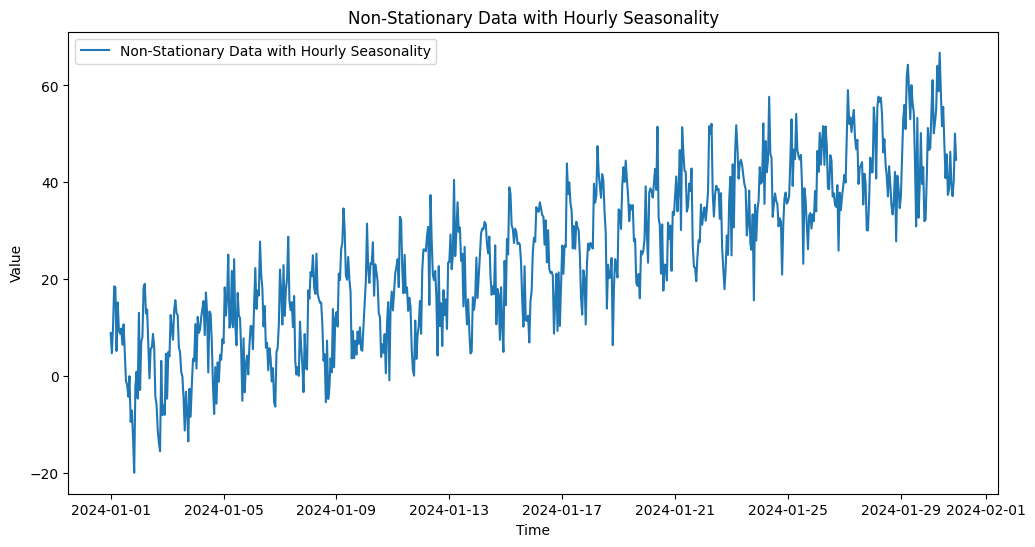

,DateTime,Value
0,2024-01-01 00:00:00,8.820262
1,2024-01-01 01:00:00,4.658518
2,2024-01-01 02:00:00,10.032772
3,2024-01-01 03:00:00,18.484157
4,2024-01-01 04:00:00,18.276208
...,...,...
715,2024-01-30 19:00:00,39.556170
716,2024-01-30 20:00:00,37.115416
717,2024-01-30 21:00:00,40.468162
718,2024-01-30 22:00:00,50.039412


In [75]:
# Set the random seed for reproducibility
np.random.seed(0)

# Generate time index for hourly data over 30 days
n_days = 30
hours_per_day = 24
n = n_days * hours_per_day
time_index = pd.date_range(start='2024-01-01', periods=n, freq='H')

# Create a trend
trend = np.linspace(0, 50, n)  # Linear trend

# Create hourly seasonality (e.g., higher values during the day, lower at night)
seasonality = 10 * np.sin(2 * np.pi * (time_index.hour / 24))

# Add noise
noise = np.random.normal(scale=5, size=n)

# Combine trend, seasonality, and noise to create non-stationary data
y = trend + seasonality + noise

# Create a DataFrame to hold the data
data = pd.DataFrame({'DateTime': time_index, 'Value': y})

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['Value'], label='Non-Stationary Data with Hourly Seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Non-Stationary Data with Hourly Seasonality')
plt.legend()
plt.show()

data

**ADF & KPSS Tests**

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [76]:
# ADF Test

adf_res = adfuller(y)
if adf_res[1] > 0.05:
    print('The time series is not ADF Stationary')
else:
    print('The time series is ADF Stationary')

# KPSS Test

kpss_res = kpss(y)
if kpss_res[1] < 0.05:
    print('The time series is not KPSS Stationary')
else:
    print('The time series is KPSS Stationary')

The time series is not ADF Stationary
The time series is not KPSS Stationary


<ipython-input-76-b0e7a9384e25>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(y)


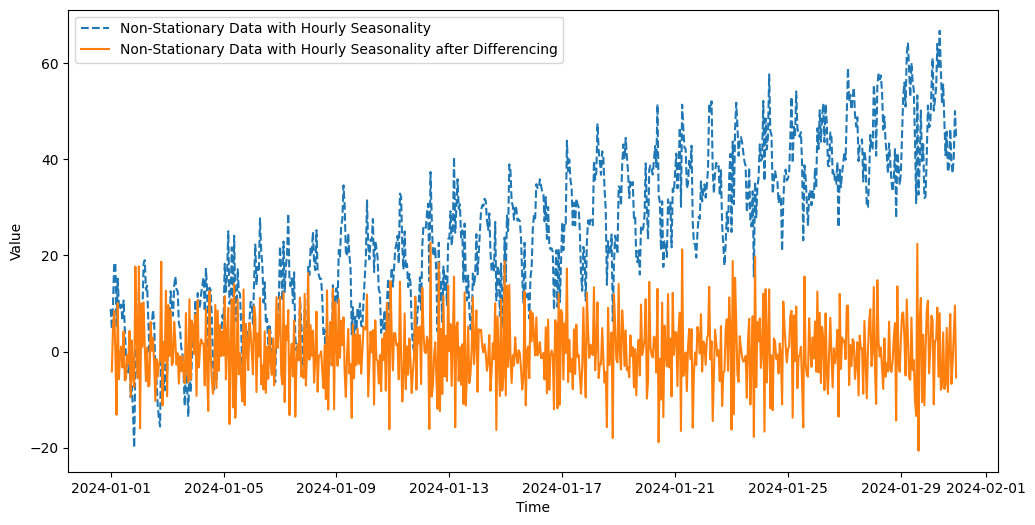

In [77]:
# Differencing to get stationary time series
data_diff = np.diff(data['Value'])

# Plot the data, and compare it to the Differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['Value'], label='Non-Stationary Data with Hourly Seasonality', linestyle='--')
plt.plot(data['DateTime'][1:], data_diff, label='Non-Stationary Data with Hourly Seasonality after Differencing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [78]:
# ADF Test

adf_res = adfuller(data_diff)
if adf_res[1] > 0.05:
    print('The time series is not ADF Stationary')
else:
    print('The time series is ADF Stationary')

# KPSS Test

kpss_res = kpss(data_diff)
if kpss_res[1] < 0.05:
    print('The time series is not KPSS Stationary')
else:
    print('The time series is KPSS Stationary')

The time series is ADF Stationary
The time series is KPSS Stationary


<ipython-input-78-8b1f2ce8533a>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(data_diff)


In [79]:
stationary_data = pd.DataFrame({'DateTime': time_index[1:], 'Value': data_diff})

stationary_data

,DateTime,Value
0,2024-01-01 01:00:00,-4.161744
1,2024-01-01 02:00:00,5.374254
2,2024-01-01 03:00:00,8.451385
3,2024-01-01 04:00:00,-0.207949
4,2024-01-01 05:00:00,-13.155634
...,...,...
714,2024-01-30 19:00:00,-6.735038
715,2024-01-30 20:00:00,-2.440754
716,2024-01-30 21:00:00,3.352746
717,2024-01-30 22:00:00,9.571250


Text(0.5, 1.0, 'Time-Varying AR(3) Coefficients')

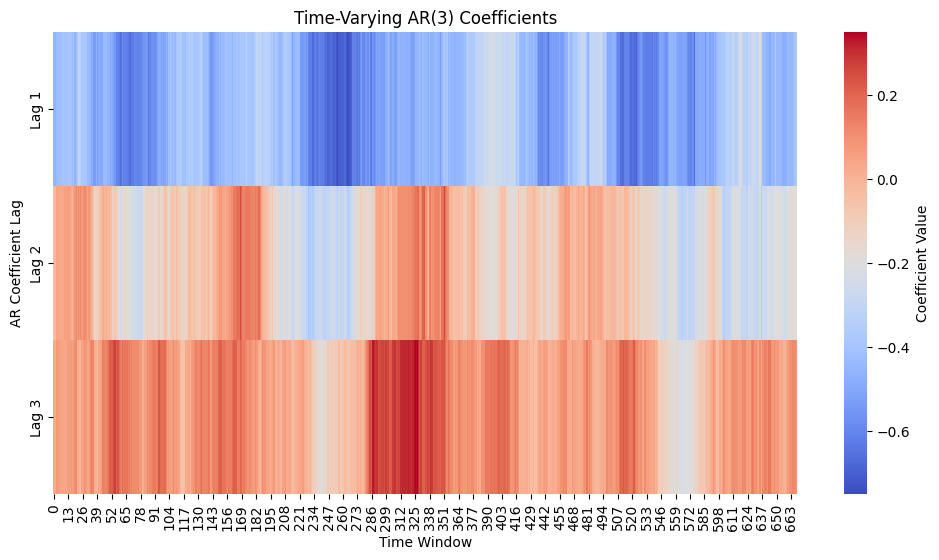

In [80]:
# Using Stationary Data

y = data_diff

# Function to fit a TVAR(3) model using rolling windows
def tvar(y, order, window_size):
    tvar_coefs = []
    for i in range(len(y) - window_size):
        window_data = y[i:i + window_size]
        model = AutoReg(window_data, lags=order, old_names=False)
        model_fit = model.fit()
        tvar_coefs.append(model_fit.params[1:])
    return np.array(tvar_coefs)

# Fit TVAR(3) model
order = 3
window_size = 50
tvar_coefs = tvar(y, order, window_size)
tvar_coefs_data = pd.DataFrame(tvar_coefs, columns=[f'Lag {i+1}' for i in range(order)])

# Plot the time-varying coefficients on a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(tvar_coefs_data.T, cmap='coolwarm', cbar_kws={'label': 'Coefficient Value'})
plt.xlabel('Time Window')
plt.ylabel('AR Coefficient Lag')
plt.title('Time-Varying AR(3) Coefficients')

Text(0.5, 1.0, 'Time-Varying AR(3) Coefficients')

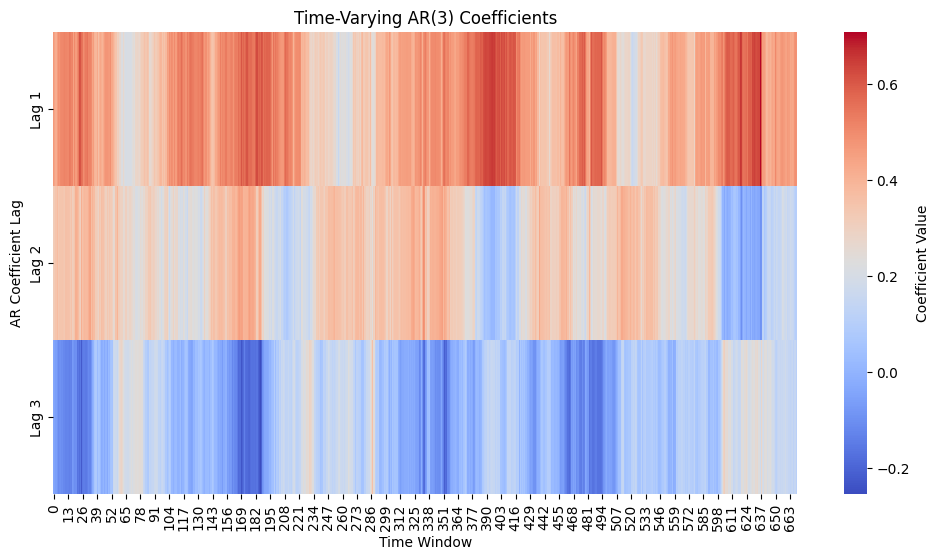

In [81]:
# Using Non-Stationary Data

y = data['Value']

# Function to fit a TVAR(3) model using rolling windows
def tvar(y, order, window_size):
    tvar_coefs = []
    for i in range(len(y) - window_size):
        window_data = y[i:i + window_size]
        model = AutoReg(window_data, lags=order, old_names=False)
        model_fit = model.fit()
        tvar_coefs.append(model_fit.params[1:])
    return np.array(tvar_coefs)

# Fit TVAR(3) model
order = 3
window_size = 50
tvar_coefs = tvar(y, order, window_size)
tvar_coefs_data = pd.DataFrame(tvar_coefs, columns=[f'Lag {i+1}' for i in range(order)])

# Plot the time-varying coefficients on a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(tvar_coefs_data.T, cmap='coolwarm', cbar_kws={'label': 'Coefficient Value'})
plt.xlabel('Time Window')
plt.ylabel('AR Coefficient Lag')
plt.title('Time-Varying AR(3) Coefficients')

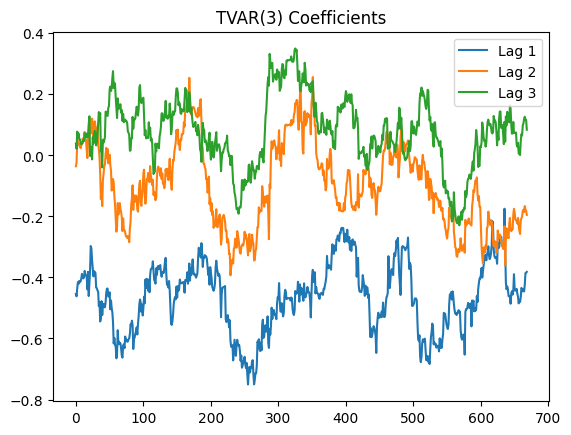

In [84]:
# Using Stationary Data

y = data_diff

# Function to fit a TVAR(3) model using rolling windows
def tvar(y, order, window_size):
    tvar_coefs = []
    for i in range(len(y) - window_size):
        window_data = y[i:i + window_size]
        model = AutoReg(window_data, lags=order, old_names=False)
        model_fit = model.fit()
        tvar_coefs.append(model_fit.params)
    return np.array(tvar_coefs)

# Fit TVAR(3) model
order = 3
window_size = 50
tvar_coefs = tvar(y, order, window_size)

# Plot the time-varying coefficients on a linechart
for i in range(1, order + 1):
    plt.plot(tvar_coefs[:, i], label=f'Lag {i}')
plt.legend()
plt.title("TVAR(3) Coefficients")
plt.show()

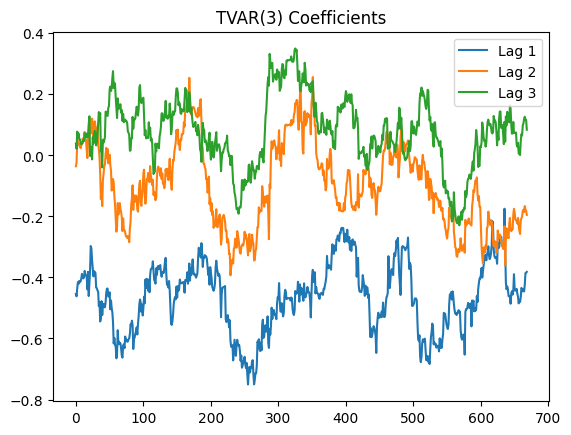

In [85]:
# Using Non-Stationary Data

y = stationary_data['Value']

# Function to fit a TVAR(3) model using rolling windows
def tvar(y, order, window_size):
    tvar_coefs = []
    for i in range(len(y) - window_size):
        window_data = y[i:i + window_size]
        model = AutoReg(window_data, lags=order, old_names=False)
        model_fit = model.fit()
        tvar_coefs.append(model_fit.params)
    return np.array(tvar_coefs)

# Fit TVAR(3) model
order = 3
window_size = 50
tvar_coefs = tvar(y, order, window_size)

# Plot the time-varying coefficients on a linechart
for i in range(1, order + 1):
    plt.plot(tvar_coefs[:, i], label=f'Lag {i}')
plt.legend()
plt.title("TVAR(3) Coefficients")
plt.show()